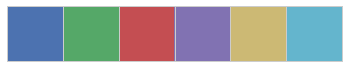

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
sns.set()
sns.set_style("whitegrid")
reso=300
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [2]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [23]:
dedd=pd.read_csv('EDDtable14Mar2018170435.txt',low_memory=False,header=0,skiprows=[0,2,3,4])

In [24]:
df=dedd.copy()
dedd.head()

,pgc,Dist,Nd,DM,eDM,C,T,L,M,S,...,Vcgp,Vmgp,Vrms,bwMass12,L_Mass12,LDC,HDC,2M++,MKgp,Icnt
0,4,50.58,1,33.52,0.4,NaN,NaN,NaN,NaN,NaN,...,4005,4048,25.0,0.0,9.747,0,0,0,0,0
1,27,150.66,1,35.89,0.5,NaN,NaN,NaN,NaN,NaN,...,10959,11275,NaN,0.0,0.000,0,0,0,0,0
2,40,116.95,1,35.34,0.5,NaN,NaN,NaN,NaN,NaN,...,6919,7045,0.0,0.0,3.960,0,0,0,0,0
3,51,240.99,1,36.91,0.5,NaN,NaN,NaN,NaN,NaN,...,14743,15315,132.0,0.0,253.333,0,0,0,0,0
4,55,73.79,1,34.34,0.4,NaN,NaN,NaN,NaN,NaN,...,4454,4507,NaN,0.0,0.000,0,0,0,0,0


In [5]:
meas=[]
for i in range(len(dedd)):
    em=0
    if dedd.DM2.iloc[i]>0:
        em+=1
    if dedd.DMsn.iloc[i]>0:
        em+=1
    if dedd.DMsp.iloc[i]>0:
        em+=1
    if dedd.DM6d.iloc[i]>0:
        em+=1
    meas+=[em]
meas=np.array(meas)

In [6]:
# no missing or 0 errors
(dedd.eD2[dedd.DM2>0]==0).sum(),(dedd.eDsp[dedd.DMsp>0]==0).sum(),(dedd.eD6d[dedd.DM6d>0]==0).sum()

(0, 0, 0)

In [7]:
len(meas)

17648

In [8]:
(np.array(meas)>1).sum()

1784

In [9]:
(np.array(meas)==0).sum()

4

(array([  4.00000000e+00,   0.00000000e+00,   1.58600000e+04,
          0.00000000e+00,   0.00000000e+00,   1.72600000e+03,
          0.00000000e+00,   5.70000000e+01,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

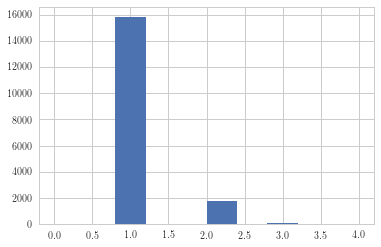

In [10]:
plt.hist(meas)

### Bootstrap

In [11]:
%%time
nbins=10000
bootp50=[] # mean error from the bootstrap for each galaxy
bootsig=[] # uncertainty of the error -> may not be a good predictor
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
ecf=[]
eqd=[]
mpgc=[]
gal=[]
boot84=[]
boot16=[]
for i,em in zip(range(len(dedd)),meas):
    tli=[]
    err=[]
    mod=[]
    if em>1:
        gal+=[dedd.Name.iloc[0]]
        if dedd.DM2.iloc[i]>0:
            km=dedd.DM2.iloc[i]
            ke=dedd.eD2.iloc[i]
            mod+=[km]
            err+=[ke]
            tli+=[(10**(np.random.normal(km,ke,nbins)/5.+1))]
        if dedd.DMsn.iloc[i]>0:
            km=dedd.DMsn.iloc[i]
            ke=0.175 # from CF3 database approx.
            mod+=[km]
            err+=[ke]
            tli+=[(10**(np.random.normal(km,ke,nbins)/5.+1))]
        if dedd.DMsp.iloc[i]>0:
            km=dedd.DMsp.iloc[i]
            ke=dedd.eDsp.iloc[i]
            mod+=[km]
            err+=[ke]
            tli+=[(10**(np.random.normal(km,ke,nbins)/5.+1))]
        if dedd.DM6d.iloc[i]>0:
            km=dedd.DM6d.iloc[i]
            ke=dedd.eD6d.iloc[i]
            mod+=[km]
            err+=[ke]
            tli+=[(10**(np.random.normal(km,ke,nbins)/5.+1))]
        tli=np.array(tli)
        mod=np.array(mod)
        err=np.array(err)
        b84=np.percentile(tli, 84,axis=0)
        b16=np.percentile(tli, 16,axis=0)
        boot84+=[np.median(b84)/1e6]
        boot16+=[np.median(b16)/1e6]
        booterr=(b84-b16)/2 # sigma draws from bootstrap for each gal
        bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
        bootp50+=[np.median(booterr)/1e6] # mean bootstrap error
        bootsig+=[((np.percentile(booterr, 84)-np.percentile(booterr, 16)))/2e6] # the error of the error
        bootmad+=[np.median(np.abs(tli - np.median(tli)))/1e6]
        dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
        wnat,avnat = weighted_std(mod,1/err**2)
        distwav=10**(avnat/5+1)/1e6
        wsti=0.461*distwav*wnat # weighted standard deviation
        ecfi=0.461*distwav/np.sqrt((1/err**2).sum()) # error according to cosmicflows
        ecf+=[ecfi]
        eqd+=[np.sqrt(ecfi**2+wsti**2)]  
        mpgc+=[dedd.pgc.iloc[i]]

CPU times: user 8.23 s, sys: 0 ns, total: 8.23 s
Wall time: 8.25 s


In [12]:
d = {'pgc':mpgc,'meas': meas[meas>1], 'H (Mpc)':bootp50, 'D (Mpc)':dboot,'P (Mpc)':ecf,'Q (Mpc)':eqd,'M (Mpc)':bootmad,'Dmin (Mpc)':boot16,'Dmax (Mpc)':boot84}
dfb = pd.DataFrame(data=d)
dfb.to_csv("cf3_bootstrap_results.csv")

### Start here if you have bootstrap results already

In [14]:
dfb=pd.read_csv('cf3_bootstrap_results.csv')

In [15]:
em=dfb.meas
dboot=dfb['D (Mpc)']
bootp50=dfb['H (Mpc)']
ecf=dfb['P (Mpc)']
eqd=dfb['Q (Mpc)']
bootmad=dfb['M (Mpc)']

In [16]:
filt=(em==2)
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]

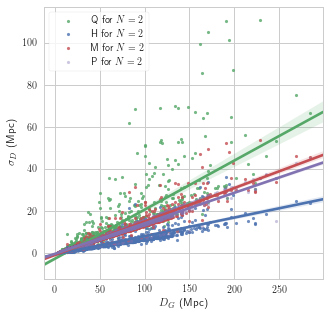

In [17]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N=2$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N=2$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N=2$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N=2$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
#plt.ylim(0,15)
plt.savefig('mnras/CF3low.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/CF3low.png', dpi=reso,transparent=True)

In [18]:
filt=(em>2)
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]

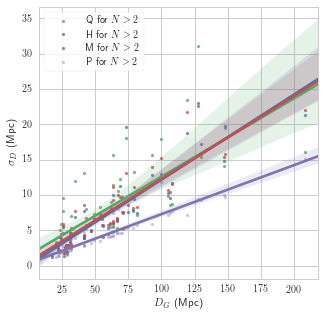

In [19]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N>2$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N>2$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N>2$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N>2$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
#plt.ylim(0,15)
plt.savefig('mnras/CF3high.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/CF3high.png', dpi=reso,transparent=True)

In [25]:
df[['pgc','DM','eDM','DMgp','eDgp','Name']][np.array(meas)==0] # all these except for NGC4625 get their distance from group

,pgc,DM,eDM,DMgp,eDgp,Name
924,5974,29.95,0.2,29.95,0.20,NGC0628
1878,12209,29.79,0.2,29.79,0.20,NGC1291
5618,42607,30.23,0.3,28.44,0.04,NGC4625
6419,47404,29.67,0.2,29.79,0.20,NGC5194


In [27]:
# measurement for NGC4625 comes from elsewhere
clm=list(df.columns)
for i in clm:
    print(df[i][df.pgc==42607].iloc[0])

42607
11.12
1
30.23
0.3
nan
nan
L
nan
nan
nan
nan
nan
nan
0.0
0.0
nan
0
0.0
0.0
0.0
0.0
0.0
nan
124152.7
411626
130.2305
75.7186
75.6936
7.8831
8.7
0.066
13.03
9.74
609
662
665
835
837
NGC4625
100491
20
28.44
0.04
4.9
nan
nan
3
46153
107.66
74.49
76.1665
13.7581
11.03
1.0
131.0
0.357
554
624
629
760
762
73.0
0.0
4.533
852
699
1002
5066893
0


In [28]:
dedd[(df.L=='L')&(df.Nd==2)] # when TRGB measurements are carried over from CF2, they are not included

,pgc,Dist,Nd,DM,eDM,C,T,L,M,S,...,Vcgp,Vmgp,Vrms,bwMass12,L_Mass12,LDC,HDC,2M++,MKgp,Icnt
137,1038,1.96,2,26.46,0.16,NaN,T,L,NaN,NaN,...,-239,-239,NaN,0.0,0.000,0,0,0,0,234
216,1641,2.00,2,26.50,0.16,NaN,T,L,NaN,NaN,...,-116,-116,NaN,0.0,0.000,0,0,0,5066497,234
288,2121,0.73,2,24.33,0.16,NaN,NaN,L,M,NaN,...,-647,-646,NaN,0.0,0.000,0,0,0,0,222
331,2429,0.81,2,24.54,0.16,NaN,T,L,NaN,NaN,...,-525,-524,NaN,0.0,0.000,852,26,0,0,222
380,2666,0.75,2,24.38,0.16,NaN,NaN,L,M,NaN,...,-669,-668,NaN,0.0,0.000,0,0,0,0,222
410,2881,3.48,2,27.71,0.16,NaN,T,L,NaN,NaN,...,-80,-80,NaN,0.0,0.000,0,0,0,0,233
413,2902,3.39,2,27.65,0.16,NaN,T,L,NaN,NaN,...,-2,-2,NaN,0.0,0.000,0,0,0,5066670,233
420,2933,3.60,2,27.78,0.16,NaN,T,L,NaN,NaN,...,-70,-70,NaN,0.0,0.000,0,0,0,0,233
527,3589,0.08,2,19.60,0.16,NaN,NaN,L,M,NaN,...,-138,-138,NaN,0.0,0.000,0,0,0,0,223
585,3974,4.70,2,28.36,0.16,NaN,T,L,NaN,NaN,...,-165,-165,NaN,0.0,0.000,0,0,0,0,331


In [29]:
dedd[(df.L=='L')&(df.Nd==1)&(np.array(meas)>0)] # also from cosmicflows

,pgc,Dist,Nd,DM,eDM,C,T,L,M,S,...,Vcgp,Vmgp,Vrms,bwMass12,L_Mass12,LDC,HDC,2M++,MKgp,Icnt
5425,41018,15.70,1,30.98,0.28,NaN,NaN,L,NaN,NaN,...,1485,1491,670.0,934.667,705.333,0,0,0,5066891,1
7309,54074,0.07,1,19.16,0.28,NaN,NaN,L,NaN,NaN,...,-222,-222,NaN,0.000,0.000,0,0,0,0,223
8018,60095,0.08,1,19.49,0.28,NaN,NaN,L,NaN,NaN,...,-340,-340,NaN,0.000,0.000,0,0,0,0,223
